# Homework 3 Part 2 Task 3 - Cross-validation
This task is similar to task 2: you will build regressors to Predict House Prices <br>
Here is the difference: we will use cross-validation to find the best hyper-parameters <br>
If the dataset is relatively small, cross-validation may lead to a better estimation <br>
Since we are in the 'big-data' and 'cloud-data' era, a one-time trainig-validation-testing split is just fine. <br>
However, you should do this task in case that your future boss gives you a small dataset and wants some results. <br>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load the training and testing datasets
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [2]:
data_train = pd.read_csv("housing_train.csv")
data_test = pd.read_csv("housing_test.csv")
data_test_y = pd.read_csv("housing_test_y.csv")
data_test['SalePrice']=data_test_y['SalePrice']
data_train['train']=1
data_test['train']=0
data = pd.concat([data_train, data_test], axis=0, sort=False)
print('data_train.shape', data_train.shape)
print('data_test.shape', data_test.shape)
print('data.shape', data.shape)

data_train.shape (1460, 82)
data_test.shape (1459, 82)
data.shape (2919, 82)


In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1


the regression target is SalePrice

In [4]:
data.head().SalePrice

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

## Handle missing values (NaN and None)
show the missing values for each feature

In [5]:
#show the missing values in a table
Missing = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'],sort=False)
Missing[Missing.sum(axis=1) > 0]

,Train,Test
MSZoning,0,4
LotFrontage,259,227
Alley,1369,1352
Utilities,0,2
Exterior1st,0,1
Exterior2nd,0,1
MasVnrType,872,894
MasVnrArea,8,15
BsmtQual,37,44
BsmtCond,37,45


<Axes: xlabel='None', ylabel='None'>

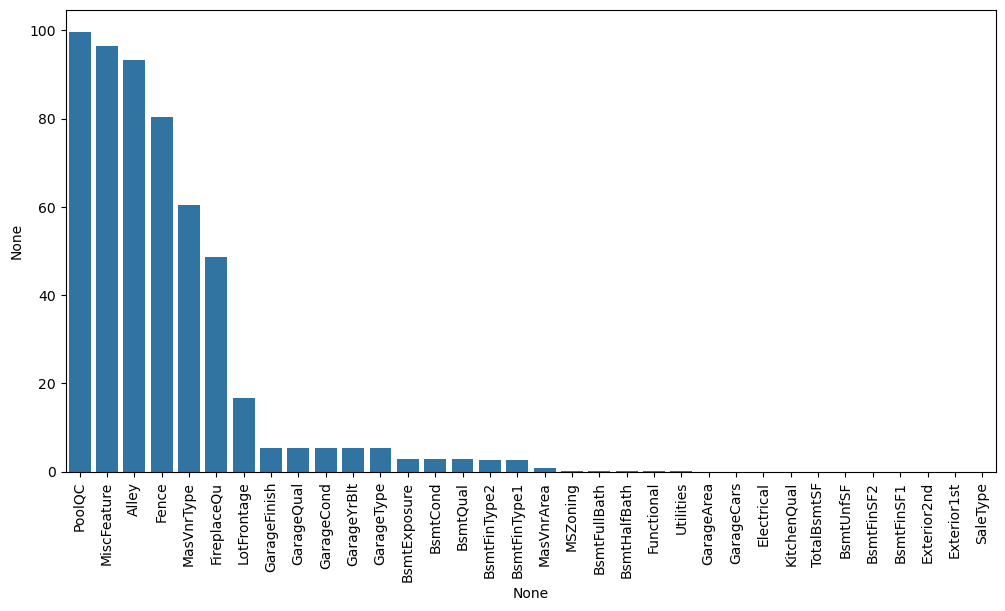

In [6]:
#show the missing values in a plot
data_missing = (data.isnull().sum(axis=0)/data.shape[0]) * 100
data_missing = data_missing.drop(data_missing[data_missing == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
sns.barplot(x=data_missing.index, y=data_missing)

From the figure, we see that nearly 100% values of the feature/column 'PoolQC' are missing <br>
We can simply delete these features (drop these columns from the table) of which >=50% values are missing

In [7]:
feature_drop = data_missing[data_missing >=50].index
feature_drop

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], dtype='object')

In [8]:
#drop the columns
data=data.drop(columns=feature_drop)
#drop Id
data=data.drop(columns='Id')

In [9]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500.0,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500.0,1
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500.0,1
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000.0,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000.0,1


For those features with < 50% missing values, we can use impute method. <br>
Missing numerical values can be imputed with a constant value, or some statistics (mean, median or most frequent) of each column in which the missing values are located. <br>
Missing categorical/non-numeric values can be imputed with the most frequent category, or a new category-'nothing'

In [10]:
numerical_column=[]
categorical_column=[]
for c in data.columns:
    v=data[c]
    v=v[~v.isnull()]
    if data[c].dtype == np.dtype('O'): # non-numeric values       
        #data[c]=data[c].fillna(v.value_counts().index[0]) # the most frequent category
        data[c]=data[c].fillna('nothing') # a new category         
        categorical_column.append(c)
    else: # numeric 
        if c != 'train' and c != 'SalePrice':
            data[c]=data[c].fillna(v.median()) 
        numerical_column.append(c)        

check if there is any missing value

In [11]:
data[data.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train


convert categorical values to numerical values using one-hot encoding <br>
note: there are other methods to encode categorical values

In [12]:
data=pd.get_dummies(data, columns=categorical_column)
data.shape

(2919, 291)

In [13]:
#the table has many new columns
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nothing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,False,False,True,False,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,False,False,True,False,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,False,False,True,False,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,False,False,True,False,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,False,False,True,False,False,False,False,False,True,False


### get training data and testing data from `data`

In [14]:
data_train = data[data['train']==1]
X_train=data_train.drop(columns=['SalePrice', 'train']).values
Y_train=data_train['SalePrice'].values

In [15]:
X_train.dtype

dtype('O')

In [16]:
X_train.shape

(1460, 289)

In [17]:
Y_train.dtype

dtype('float64')

In [18]:
data_test = data[data['train']==0]
X_test=data_test.drop(columns=['SalePrice', 'train']).values
Y_test=data_test['SalePrice'].values

### Train a regression model to predict SalePrice

Text(0.5, 1.0, 'histogram of SalePrice in training set')

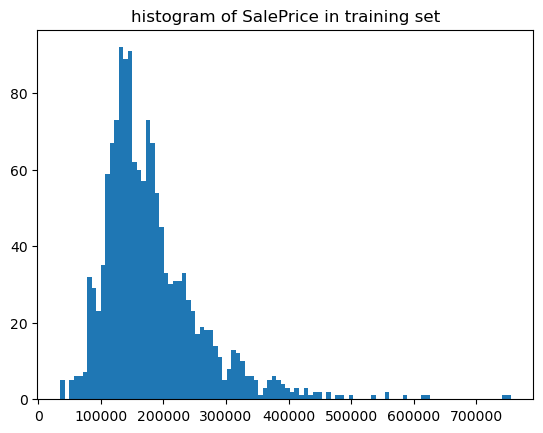

In [19]:
plt.hist(data_train.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in training set')

Text(0.5, 1.0, 'histogram of SalePrice in testing set')

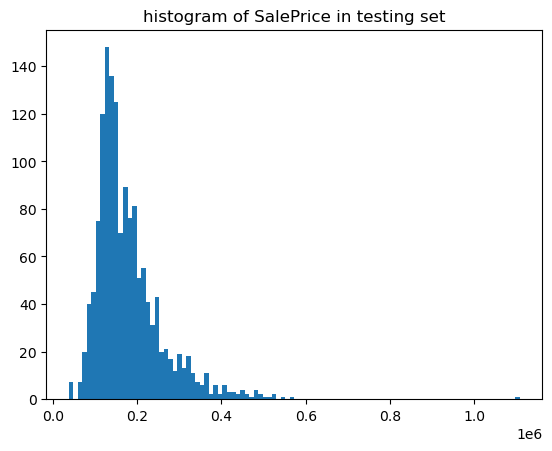

In [20]:
plt.hist(data_test.SalePrice.values, bins=100);
plt.title('histogram of SalePrice in testing set')

### Predict SalePrice using a linear regression model

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

show the training result

(0.0, 1000000.0, 0.0, 1000000.0)

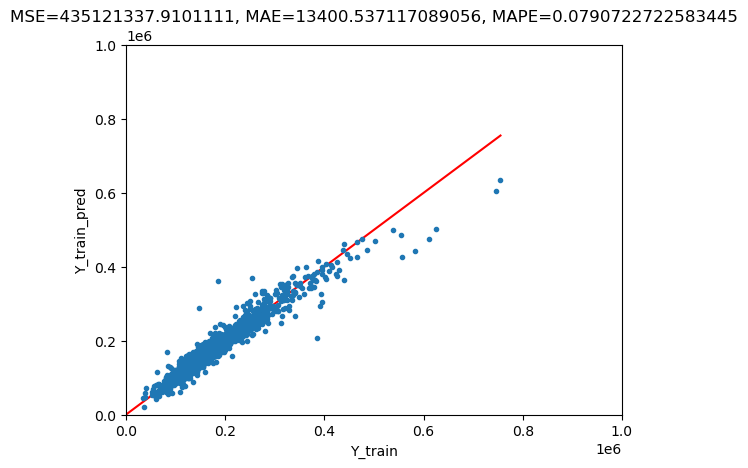

In [22]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

show the testing result

(0.0, 1000000.0, 0.0, 1000000.0)

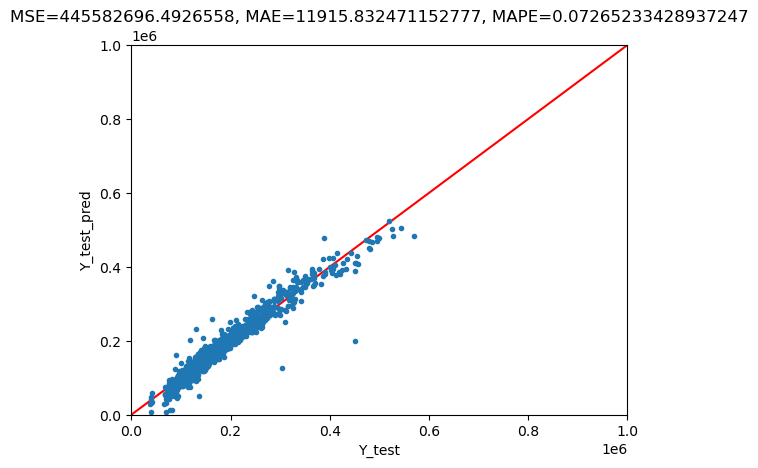

In [23]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', MAPE='+str(MAPE))
plt.axis([0, 1e6, 0, 1e6])

In [24]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

319

Perform 10-fold cross valiation to get the average MAPE (or other accuracy measurements)

In [25]:
#attention: if you choose to use GridSearchCV
#           it assumes a better model has a higher score
#           thus, my_scorer should return -MAPE as the score of the model
def my_scorer(model, X, y):
    y_pred = model.predict(X)
    #MSE = np.mean((y_pred - y)**2)
    #MAE = np.mean(np.abs(y_pred - y))
    MAPE =  np.mean(np.abs(y_pred - y)/y)
    return MAPE
#
from sklearn.model_selection import cross_val_score
MAPE_array = cross_val_score(linear_model, X_train, Y_train, cv=10, scoring=my_scorer)
MAPE_array

array([1.11282701e-01, 6.88250016e+01, 1.08615645e-01, 1.20155311e-01,
       1.20893875e-01, 1.05430859e-01, 4.40880360e+02, 1.43771375e+02,
       1.22901760e-01, 9.40766243e-02])

Linear regression seems to be fine except for a few testing data points <br>
Next, let's try nonlinear regression models and see if we can get better results

## Your task begins here
### Predict SalePrice using nonlinear regression models
Try the two types of models <br>
(1) KNN (hyperparameter is `n_neighbors`) <br>
(2) random forest <br>
&nbsp;&nbsp;&nbsp; It has many hyperparameters. <br>
&nbsp;&nbsp;&nbsp; You can just focus on `max_depth` <br>
(3) xgboost <br>
&nbsp;&nbsp;&nbsp; It has many hyperparameters. <br>
&nbsp;&nbsp;&nbsp; You can just focus on `max_depth` <br>

For model selection (i.e. to determine the hyperparameters), we apply cross-validation to get the average MAPE (or other measurements) on the validation sets. Try different sets of hyperparameters, and find the best hyperparameters associated with the minimum average MAPE. <br>
A simple strategy is grid search, which you will use to find the optimal hyperparameters. <br>
You may use the function `GridSearchCV` in https://scikit-learn.org/stable/modules/grid_search.html <br>
or write a for loop to do grid search, like this 
```python
MAPE_average_list=[]
hyperparameter_list=[1, 2, 3, 4, 5]
for hyperparameter in hyperparameter_list:
    my_model=SomeRegressor(hyperparameter) # set random_state=0 if possible
    MAPE_array = cross_val_score(my_model, X_train, Y_train, cv=10, scoring=my_scorer, n_jobs=4)
    MAPE_average_list.append(MAPE_array.mean())
MAPE_average_list=np.array(MAPE_average_list)
#hyperparameter_best = hyperparameter_list[np.argmin(MAPE_average_list)]
#or hyperparameter_best is the point at which the curve hyperparameter~MAPE becomes flat 
plt.plot(hyperparameter_list, MAPE_average_list, '.-b')
plt.xlabel('hyperparameter')
plt.ylabel('MAPE')  
```    
`cross_val_score` is imported from sk-learn <br>
note: set 'n_jobs=4' to use multiple (4) cpu cores <br>
After the best hyperparameter is found, fit the model (using the best hyperparameter) to the whole training set, <br> 
and evaluate the model on the testing set (`X_test`, `Y_test`) to get MSE, MAE and MAPE  <br>
Do not use MSE/MAE/MAPE on the testing set for tuning hyperparameters, which will be 'cheating' <br>

Plot `hyperparameter` vs `MAPE` <br>
Plot `Y_train` vs `Y_train_pred`  <br>
Plot `Y_test` vs `Y_test_pred`  <br>
Show the values of MSE, MAE and MAPE on the traning set and the testing set <br>

#### KNeighborsRegressor

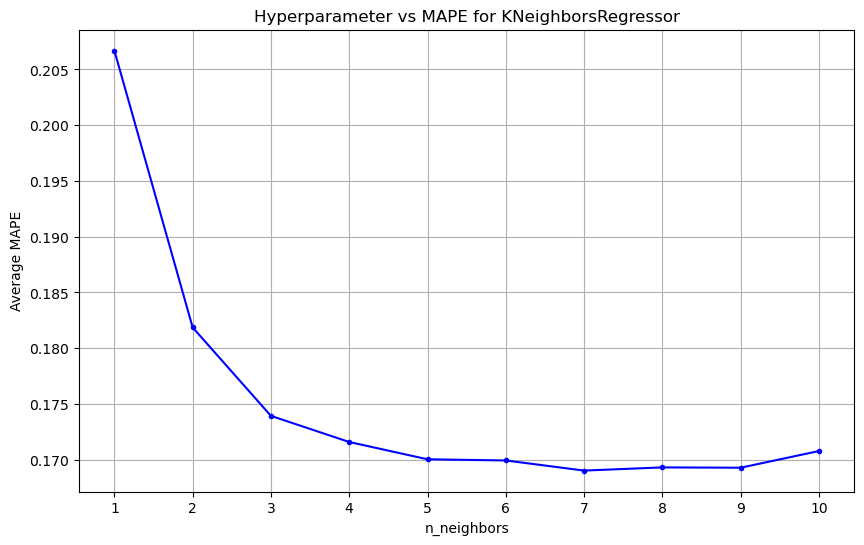

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt

# Define the model
knn = KNeighborsRegressor()

# Define the hyperparameter grid
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_absolute_percentage_error', n_jobs=4)

# Fit the model to the training data
grid_search.fit(X_train, Y_train)

# Get the best hyperparameter
best_n_neighbors = grid_search.best_params_['n_neighbors']

# Get the average MAPE from the grid search
mape_average = -grid_search.best_score_

# Plot hyperparameter vs MAPE
plt.figure(figsize=(10, 6))
plt.plot(param_grid['n_neighbors'], -grid_search.cv_results_['mean_test_score'], '.-b')
plt.xlabel('n_neighbors')
plt.ylabel('Average MAPE')
plt.title('Hyperparameter vs MAPE for KNeighborsRegressor')
plt.xticks(param_grid['n_neighbors'])
plt.grid()
plt.show()


In [28]:
best_n_neighbors

7

build a KNeighborsRegressor using the best hyperparameter <br>
fit it to the training data and test it on the testing data

In [29]:
# Build the KNeighborsRegressor model using the best hyperparameter
knn_best = KNeighborsRegressor(n_neighbors=best_n_neighbors)

# Fit the model to the training data
knn_best.fit(X_train, Y_train)

# Predict on the training data
train_predictions = knn_best.predict(X_train)

# Predict on the testing data
test_predictions = knn_best.predict(X_test)


show the training result

Training MAPE: 14.37%
Training MSE: 1573480679.59


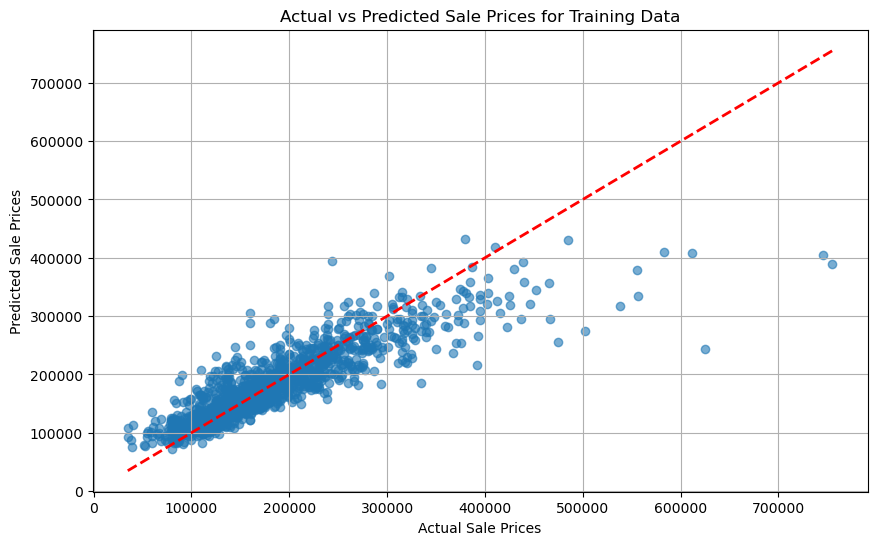

In [32]:
# Calculate the Mean Absolute Percentage Error (MAPE) for training and testing predictions
train_mape = np.mean(np.abs((Y_train - train_predictions) / Y_train)) * 100
test_mape = np.mean(np.abs((Y_test - test_predictions) / Y_test)) * 100
train_mse = mean_squared_error(Y_train, train_predictions)

# Display the results
print(f'Training MAPE: {train_mape:.2f}%')
print(f'Training MSE: {train_mse:.2f}')
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, train_predictions, alpha=0.6)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Sale Prices for Training Data')
plt.grid()
plt.show()



show the testing result

Testing MSE: 2010223312.79
Testing MAPE: 15.31%


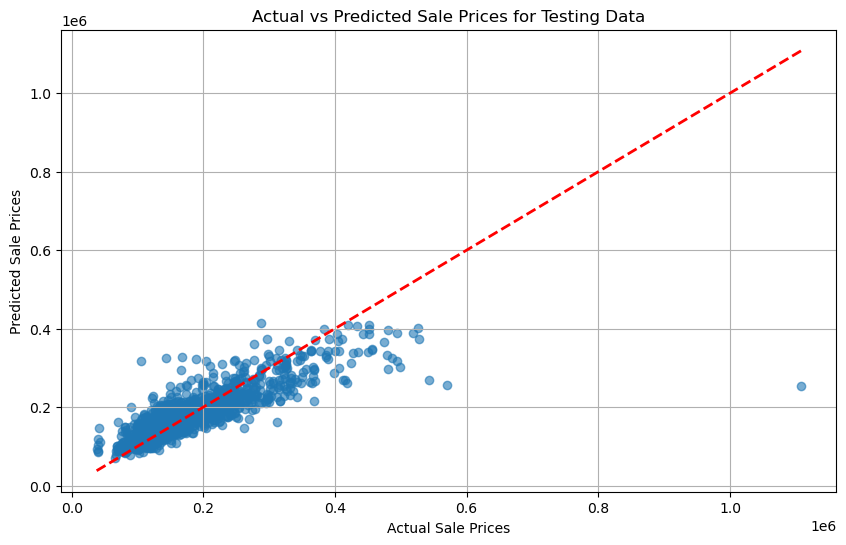

In [33]:
# Predict on the testing data
test_predictions = knn_best.predict(X_test)

# Calculate the Mean Absolute Percentage Error (MAPE) for testing predictions
test_mape = np.mean(np.abs((Y_test - test_predictions) / Y_test)) * 100

# Display the results

# Calculate the Mean Squared Error (MSE) for training and testing predictions

test_mse = mean_squared_error(Y_test, test_predictions)

# Display the results

print(f'Testing MSE: {test_mse:.2f}')

print(f'Testing MAPE: {test_mape:.2f}%')
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, test_predictions, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Sale Prices for Testing Data')
plt.grid()
plt.show()


#### RandomForestRegressor

In [43]:
from sklearn.ensemble import RandomForestRegressor
#use a for loop to do 10-fold cross-valiation to find the best max_depth

# Define the range of max_depth values to test
max_depths = np.array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

# Store the mean cross-validated scores for each max_depth
mean_scores = []

# Perform 10-fold cross-validation for each max_depth
for depth in max_depths:
    model = RandomForestRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train, Y_train, cv=10, scoring='neg_mean_squared_error')
    mean_scores.append(-scores.mean())  # Store the negative mean squared error

# Find the best max_depth
best_max_depth = max_depths[mean_scores.index(min(mean_scores))]
print(f'Best max_depth: {best_max_depth}')


Best max_depth: 31


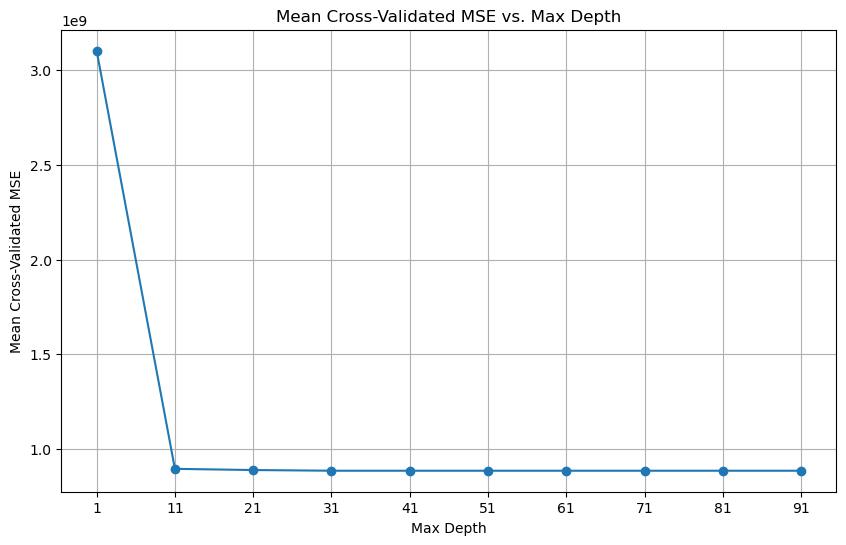

In [44]:
#plot and find the best max_depth
import matplotlib.pyplot as plt

# Plot the mean cross-validated scores against max_depth values
plt.figure(figsize=(10, 6))
plt.plot(max_depths, mean_scores, marker='o')
plt.title('Mean Cross-Validated MSE vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean Cross-Validated MSE')
plt.xticks(max_depths)
plt.grid()
plt.show()


build a RandomForestRegressor using the best hyperparameter <br> 
fit it to the training data and test it on the testing data

In [45]:
# Create and fit the RandomForestRegressor using the best max_depth
rf_model = RandomForestRegressor(max_depth=best_max_depth, random_state=42)
rf_model.fit(X_train, Y_train)

# Test the model on the testing data
Y_pred = rf_model.predict(X_test)

show the training result

Training Set Performance:
Mean Squared Error: 120002500.23
R^2 Score: 0.98


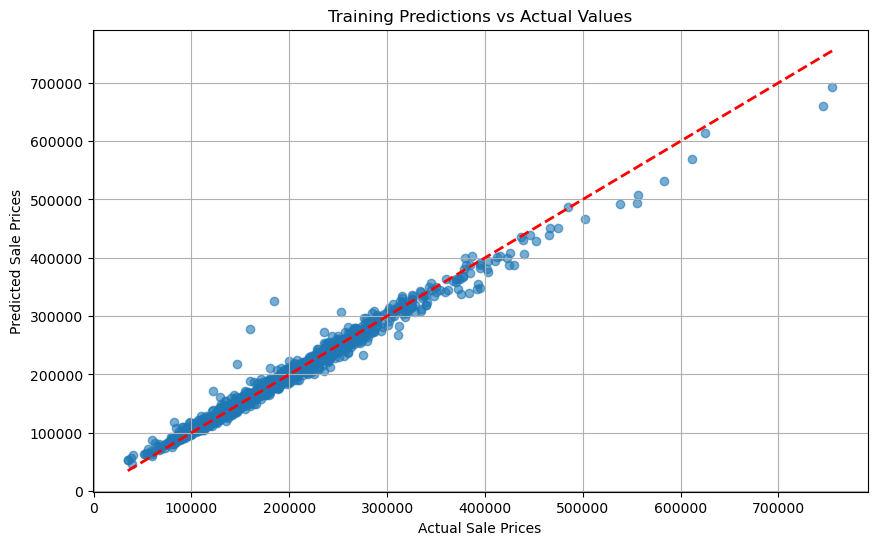

In [46]:
# Calculate and print the training set performance metrics
from sklearn.metrics import mean_squared_error, r2_score

# Predictions on the training set
train_predictions = rf_model.predict(X_train)

# Calculate metrics
mse_train = mean_squared_error(Y_train, train_predictions)
r2_train = r2_score(Y_train, train_predictions)

# Print the results
print("Training Set Performance:")
print(f"Mean Squared Error: {mse_train:.2f}")
print(f"R^2 Score: {r2_train:.2f}")

# Visualize the training predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(Y_train, train_predictions, alpha=0.6)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'r--', lw=2)
plt.title('Training Predictions vs Actual Values')
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.grid()
plt.show()



show the testing result

Testing Set Performance:
Mean Squared Error: 568898164.17
R^2 Score: 0.91


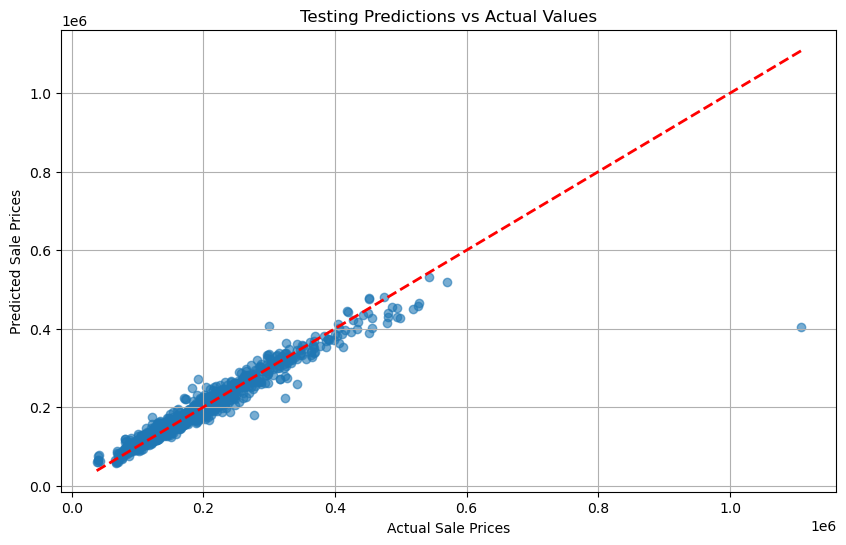

In [47]:
# Calculate and print the testing set performance metrics
from sklearn.metrics import mean_squared_error, r2_score

# Predictions on the testing set
test_predictions = rf_model.predict(X_test)

# Calculate metrics
mse_test = mean_squared_error(Y_test, test_predictions)
r2_test = r2_score(Y_test, test_predictions)

# Print the results
print("Testing Set Performance:")
print(f"Mean Squared Error: {mse_test:.2f}")
print(f"R^2 Score: {r2_test:.2f}")

# Visualize the testing predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, test_predictions, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.title('Testing Predictions vs Actual Values')
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.grid()
plt.show()


#### XGBRegressor
https://anaconda.org/anaconda/py-xgboost

In [48]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
#try to use GridSearchCV to do 10-fold cross-valiation to find the best max_depth
#set random_state=0, objective='reg:squarederror'
#read the comments in the cell of "my_scorer", or you can use the "built-in" scorer in sk-learn
param_grid = {
    'max_depth': [ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = XGBRegressor(random_state=0, objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=10, 
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best parameters found: ", grid_search.best_params_)


Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}


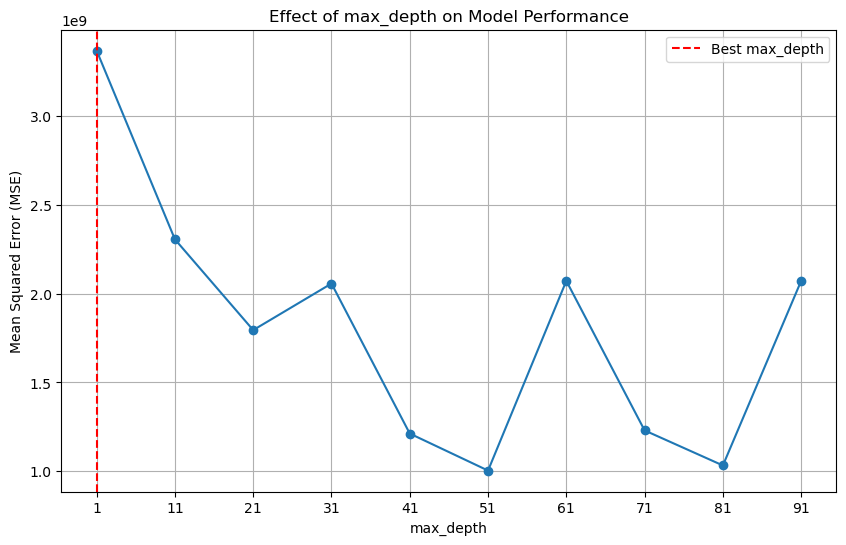

In [49]:
#plot and find the best max_depth
import matplotlib.pyplot as plt

# Extract the best max_depth from the grid search results
best_max_depth = grid_search.best_params_['max_depth']

# Create a plot to visualize the effect of max_depth on the model performance
plt.figure(figsize=(10, 6))
plt.plot(param_grid['max_depth'], 
         -grid_search.cv_results_['mean_test_score'][:len(param_grid['max_depth'])], 
         marker='o')
plt.title('Effect of max_depth on Model Performance')
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(param_grid['max_depth'])
plt.grid()
plt.axvline(x=best_max_depth, color='r', linestyle='--', label='Best max_depth')
plt.legend()
plt.show()


build a XGBRegressor using the best hyperparameter and fit it to the training data

In [56]:
best_params = grid_search.best_params_
xgb_best_model = XGBRegressor(max_depth=best_params['max_depth'], 
                               n_estimators=best_params['n_estimators'], 
                               learning_rate=best_params['learning_rate'], 
                               random_state=0, 
                               objective='reg:squarederror')

xgb_best_model.fit(X_train, Y_train)

Y_train_pred = xgb_best_model.predict(X_train)

show the training result

In [57]:


# Calculate and print the Mean Absolute Percentage Error (MAPE) for the training set
mape_train = np.mean(np.abs((Y_train - Y_train_pred) / Y_train)) * 100
print(f'MAPE for Training Set: {mape_train:.2f}%')
# Generate predictions on the testing set
Y_test_pred = xgb_best_model.predict(X_test)

# Calculate and print the Mean Absolute Percentage Error (MAPE) for the testing set
mape_test = np.mean(np.abs((Y_test - Y_test_pred) / Y_test)) * 100
print(f'MAPE for Testing Set: {mape_test:.2f}%')


MAPE for Training Set: 8.20%
MAPE for Testing Set: 5.38%


show the testing result

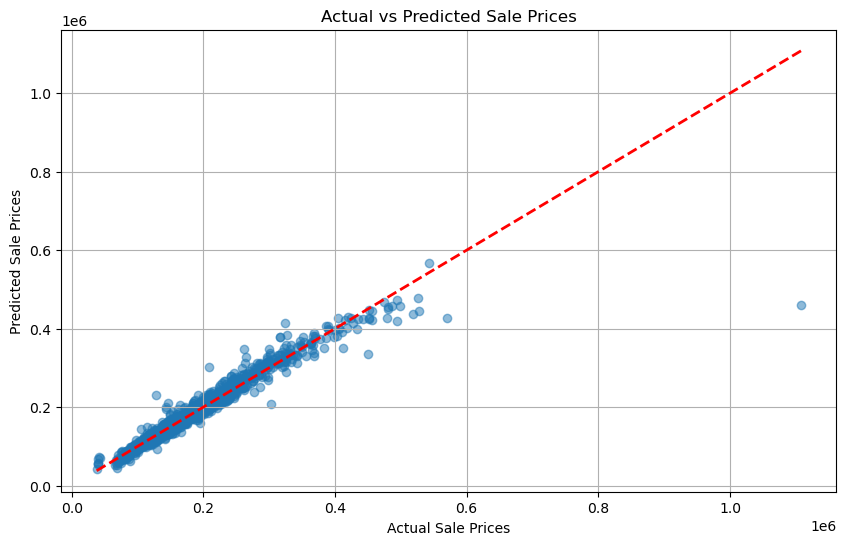

          Actual      Predicted
0  120376.994315  115110.070312
1  152387.635505  163912.953125
2  185025.193763  185438.187500
3  198385.651258  184657.578125
4  185934.885245  214777.531250


In [58]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values for the testing set
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_test_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Sale Prices')
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.grid()
plt.show()

# Display the first few predictions alongside actual values
results_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_test_pred})
print(results_df.head())


In [59]:
np.sum(np.abs(Y_test - Y_test_pred)/Y_test>0.1)

167

In this task, linear model is as good as nonlinear models <br>